## This notebook aims to visualize the different asset distributions produced by CGAN

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
import sys
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../../"))
sys.path.insert(0, parent_dir)

from utilities.gan_plotting import extensive_plotting
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical
from sklearn.preprocessing import StandardScaler

from dotenv.main import load_dotenv
load_dotenv(override=True)
import os


In [2]:
import os
print(os.getcwd())

c:\Users\nicka\master-thesis\internal_models\GANs\tuned_GANS


### Parameters

In [3]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Note to self -- We only test assets MSCIWORLD, HY and EONIA

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0, 1, 2, 3, 4, 5, 6]#[0,1,2,4]
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

## TRAINING CGAN

In [6]:
def plot_generated_scenarios(scenarios, title="Generated Scenarios", num_samples=10):
    """
    Plot a sample of generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      num_samples (int): Number of scenarios to randomly sample and plot.
    """
    # Sample a few scenarios to avoid overcrowding the plot.
    sample_indices = np.random.choice(scenarios.shape[0], size=min(num_samples, scenarios.shape[0]), replace=False)
    sampled_scenarios = scenarios[sample_indices, :]
    
    plt.figure(figsize=(12, 6))
    for scenario in sampled_scenarios:
        plt.plot(scenario, alpha=0.7)
    plt.title(title)
    plt.xlabel("Days")
    plt.ylabel("Returns")
    plt.grid(True)
    plt.show()

def plot_generated_distribution(scenarios, title="Distribution of Cumulative Returns", bins=50):
    """
    Plot the distribution of cumulative returns computed from the generated scenarios.
    
    Parameters:
      scenarios (np.array): Array of shape (num_scenarios, window_size) with generated return sequences.
      title (str): Title for the plot.
      bins (int): Number of bins for the histogram.
    """
    # Compute cumulative returns for each scenario.
    cumulative_returns = np.array([np.prod(1 + scenario) - 1 for scenario in scenarios])
    
    plt.figure(figsize=(10, 6))
    plt.hist(cumulative_returns, bins=bins, density=True, alpha=0.6, color='b')
    plt.title(title)
    plt.xlabel("Cumulative Return")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


In [ ]:
from astrid_GAN import AstridGAN
from NOVAGAN import NovaGAN


gan_dict = {}

# Dictionary to store generated scenarios by asset and date.
# Structure: { asset_name: { date: generated_scenarios, ... }, ... }
scenarios_results = {}

for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
    print(f"Training GAN for {asset_name}...")
    asset_returns = returns_df[asset_name]
    
    gan = NovaGAN(asset_returns, asset_name)
    gan.train()
    print(f"Finished training GAN for {asset_name}.\n")
    
    scenarios = gan.generate_scenarios(num_scenarios=10000)
    print(f"Finished generating scenarios for {asset_name}.\n")
    
    gan_dict[asset_name] = gan

    initial_date = returns_df.index[-1]
    scenarios_results.setdefault(asset_name, {})[initial_date] = scenarios
    print(f"{asset_name}: Stored initial generated scenarios for {initial_date}.")


for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    foundNAN = False
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        print("date", test_day)

        scenarios = gan.generate_new_scenarios_from_return(new_return, test_day, save=False, num_scenarios=10000)
        has_inf = np.isinf(scenarios).any()
        has_nan = np.isnan(scenarios).any()

        if has_nan or has_inf:
            print("FOUND NAN")
            foundNAN = True
            break

        #plot_generated_scenarios(scenarios, title=f"Generated Scenarios for {asset_name} on {test_day}")
        #plot_generated_distribution(scenarios, title=f"Distribution of Cumulative Returns for {asset_name} on {test_day}")
        print(f"{asset_name}: Generated new distribution on {test_day}.")

        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
    
    if foundNAN: break

# At this point, scenarios_results contains the generated scenario distribution for each asset keyed by date.

'''
# Online training during the test period
# Assume test_returns_df contains daily returns for the test period

for test_day in test_returns_df.index:
    for asset_name in test_returns_df.columns:
        new_return = test_returns_df.loc[test_day, asset_name]
        gan = gan_dict[asset_name]
        
        # Process the new return (online_training handles fine-tuning or full retraining as needed)
        print("date", test_day)


        gan.online_training(new_return)
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        # Generate scenarios with the updated GAN
        scenarios = gan.generate_scenarios(save=False, num_scenarios=10000)
        
        # Store the generated scenarios for this test day
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
        
for asset_name in tqdm(test_returns_df.columns, desc="Updating GANs", unit="asset"):
    asset_returns = returns_df[asset_name]
    
    for test_day in test_returns_df.index:
        new_return = test_returns_df.loc[test_day, asset_name]
        new_row = pd.DataFrame({asset_name: [new_return]}, index=[test_day])
        asset_returns = pd.concat([asset_returns, new_row])
        
        gan = NovaGAN(asset_returns, asset_name)
        
        # You might want to add a print statement inside the GAN training loop
        # to check the batch size, for example, in the beginning of gan.train():
        gan.train()
        
        print(f"{asset_name}: Processed online update for new return on {test_day}.")
        
        scenarios = gan.generate_scenarios(save=False, num_scenarios=10000)
        scenarios_results.setdefault(asset_name, {})[test_day] = scenarios
        
        print(f"{asset_name}: Stored generated scenarios for {test_day}.")
'''

Training GANs:   0%|          | 0/7 [00:00<?, ?asset/s]

Training GAN for REEL...
[Epoch 0/5000] Completed.
[Epoch 1/5000] Completed.
[Epoch 2/5000] Completed.
[Epoch 3/5000] Completed.
[Epoch 4/5000] Completed.
[Epoch 5/5000] Completed.
[Epoch 6/5000] Completed.
[Epoch 7/5000] Completed.
[Epoch 8/5000] Completed.
[Epoch 9/5000] Completed.
[Epoch 10/5000] Completed.
[Epoch 11/5000] Completed.
[Epoch 12/5000] Completed.
[Epoch 13/5000] Completed.
[Epoch 14/5000] Completed.
[Epoch 15/5000] Completed.
[Epoch 16/5000] Completed.
[Epoch 17/5000] Completed.
[Epoch 18/5000] Completed.
[Epoch 19/5000] Completed.
[Epoch 20/5000] Completed.
[Epoch 21/5000] Completed.
[Epoch 22/5000] Completed.
[Epoch 23/5000] Completed.
[Epoch 24/5000] Completed.
[Epoch 25/5000] Completed.
[Epoch 26/5000] Completed.
[Epoch 27/5000] Completed.
[Epoch 28/5000] Completed.
[Epoch 29/5000] Completed.
[Epoch 30/5000] Completed.
[Epoch 31/5000] Completed.
[Epoch 32/5000] Completed.
[Epoch 33/5000] Completed.
[Epoch 34/5000] Completed.
[Epoch 35/5000] Completed.
[Epoch 36/500

Training GANs:  14%|█▍        | 1/7 [1:52:06<11:12:39, 6726.52s/asset]

[Epoch 4999/5000] Completed.
Finished training GAN for REEL.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_REEL_final_scenarios.pt
Finished generating scenarios for REEL.

REEL: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for PE...
[Epoch 0/5000] Completed.
[Epoch 1/5000] Completed.
[Epoch 2/5000] Completed.
[Epoch 3/5000] Completed.
[Epoch 4/5000] Completed.
[Epoch 5/5000] Completed.
[Epoch 6/5000] Completed.
[Epoch 7/5000] Completed.
[Epoch 8/5000] Completed.
[Epoch 9/5000] Completed.
[Epoch 10/5000] Completed.
[Epoch 11/5000] Completed.
[Epoch 12/5000] Completed.
[Epoch 13/5000] Completed.
[Epoch 14/5000] Completed.
[Epoch 15/5000] Completed.
[Epoch 16/5000] Completed.
[Epoch 17/5000] Completed.
[Epoch 18/5000] Completed.
[Epoch 19/5000] Completed.
[Epoch 20/5000] Completed.
[Epoch 21/5000] Completed.
[Epoch 22/5000] Completed.
[Epoch 23/5000] Completed.
[Epoch 24/5000] Completed.
[Epoch 25/5000] Completed.
[Epoch 26/5000] C

Training GANs:  29%|██▊       | 2/7 [3:40:41<9:10:09, 6602.00s/asset] 

[Epoch 4999/5000] Completed.
Finished training GAN for PE.

Generated scenarios saved to: generated_CGAN_output_test\generated_returns_PE_final_scenarios.pt
Finished generating scenarios for PE.

PE: Stored initial generated scenarios for 2019-12-31 00:00:00.
Training GAN for MSCIWORLD...
[Epoch 0/5000] Completed.
[Epoch 1/5000] Completed.
[Epoch 2/5000] Completed.
[Epoch 3/5000] Completed.
[Epoch 4/5000] Completed.
[Epoch 5/5000] Completed.
[Epoch 6/5000] Completed.
[Epoch 7/5000] Completed.
[Epoch 8/5000] Completed.
[Epoch 9/5000] Completed.
[Epoch 10/5000] Completed.
[Epoch 11/5000] Completed.
[Epoch 12/5000] Completed.
[Epoch 13/5000] Completed.
[Epoch 14/5000] Completed.
[Epoch 15/5000] Completed.
[Epoch 16/5000] Completed.
[Epoch 17/5000] Completed.
[Epoch 18/5000] Completed.
[Epoch 19/5000] Completed.
[Epoch 20/5000] Completed.
[Epoch 21/5000] Completed.
[Epoch 22/5000] Completed.
[Epoch 23/5000] Completed.
[Epoch 24/5000] Completed.
[Epoch 25/5000] Completed.
[Epoch 26/5000] Co

In [ ]:
returns_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-12-23,0.000807,-0.006826,0.000148,-0.000395,-0.000994,0.000516,-0.000045
2019-12-24,0.003047,0.001789,0.000329,0.001135,-0.000096,0.000122,-0.000015
2019-12-27,0.012164,0.003310,-0.000870,0.001971,0.001809,0.000789,-0.000015
2019-12-30,-0.004847,-0.005184,-0.008396,-0.001701,-0.004516,0.000307,-0.000045
2019-12-31,0.002186,-0.000405,0.000325,-0.000746,0.000056,0.000160,-0.000015


In [ ]:
from internal_models.multivariate_GAN.simple_gan_portfolio import SimpleGANPortfolio
from internal_models.multivariate_GAN.students_copula_GAN import StudentCopula

## We need to get rolling Delta BOF

In [ ]:
entire_df = pd.concat([returns_df, test_returns_df])

entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [ ]:
test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
print("Test end date:", test_end_date)

# Find the index location of the test_start_date in entire_df
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)

# Slice 252 rows before that index
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

Test end date: 2020-12-28 00:00:00


,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2019-01-03,0.000449,-0.016792,-0.017998,0.003209,-0.002739,0.000322,-0.00001
2019-01-04,0.017480,0.029982,0.025947,-0.004488,-0.002372,0.006997,-0.00001
2019-01-07,0.004902,0.016009,0.003607,0.000024,-0.001484,0.006122,-0.00003
2019-01-08,0.015357,0.012384,0.010125,-0.000592,-0.001053,0.004209,-0.00001
2019-01-09,-0.003836,0.003621,0.001916,0.001019,0.001938,0.004650,-0.00001


In [ ]:
historical_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


In [ ]:
entire_df.tail()

,REEL,PE,MSCIWORLD,IG,GOV,HY,EONIA
Date,,,,,,,
2020-12-21,-0.021011,-0.009039,-0.006195,0.000340,0.000378,-0.002352,-0.000046
2020-12-22,0.010600,0.007414,0.002932,0.001471,0.001006,0.001066,-0.000015
2020-12-23,0.021998,0.011317,0.001690,-0.002486,-0.004044,0.000866,-0.000016
2020-12-24,0.004674,0.002335,0.003177,0.001586,0.000048,0.000539,-0.000015
2020-12-28,0.000842,0.000271,0.004125,0.000775,0.002064,0.002635,-0.000046


# CASE 1

- We first calculate realized delta BOF for a given window

In [ ]:
# CALCULATE DELTA BOF ARRAY
eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

portfolio_returns = (historical_df * weights).sum(axis=1)

portfolio_value = assets_0 * (1 + portfolio_returns).cumprod()

liabilities = liabilities_0 * (1 + eonia).cumprod()

bof = portfolio_value - liabilities

daily_delta_bof = bof.diff().fillna(0)


rolling_delta_bof = daily_delta_bof.rolling(window=252).sum()


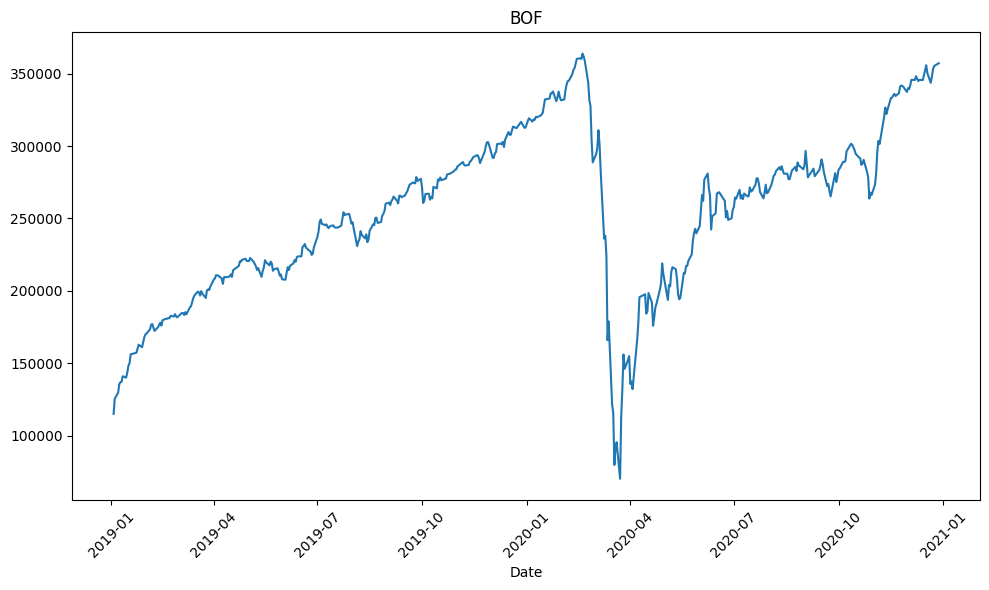

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(bof.index, bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("BOF")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

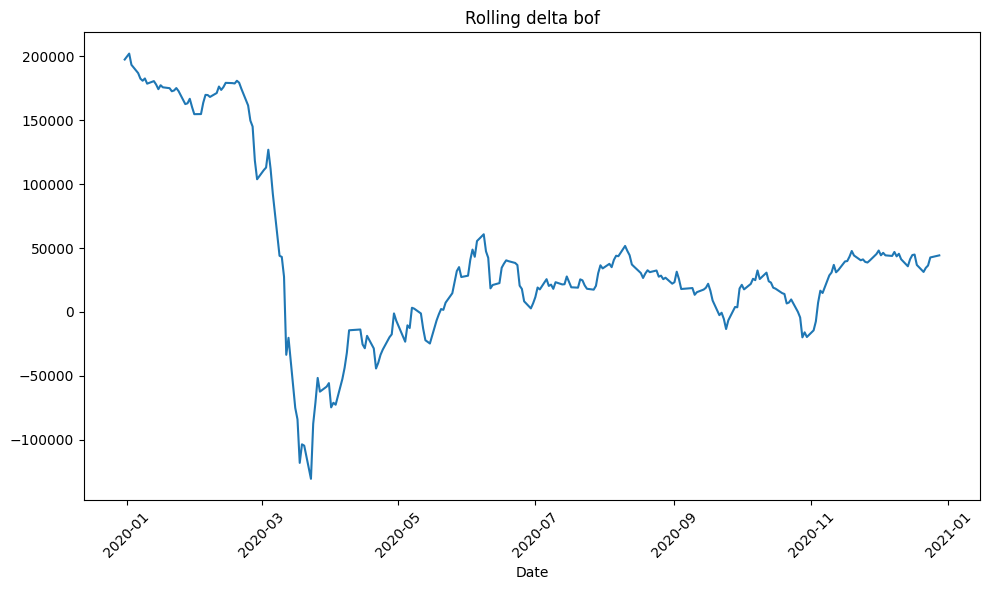

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("Rolling delta bof")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

# Case 2

Same, assuming constant BOF0

In [ ]:
bof.loc["2019-12-31"]

np.float64(312804.51417605917)

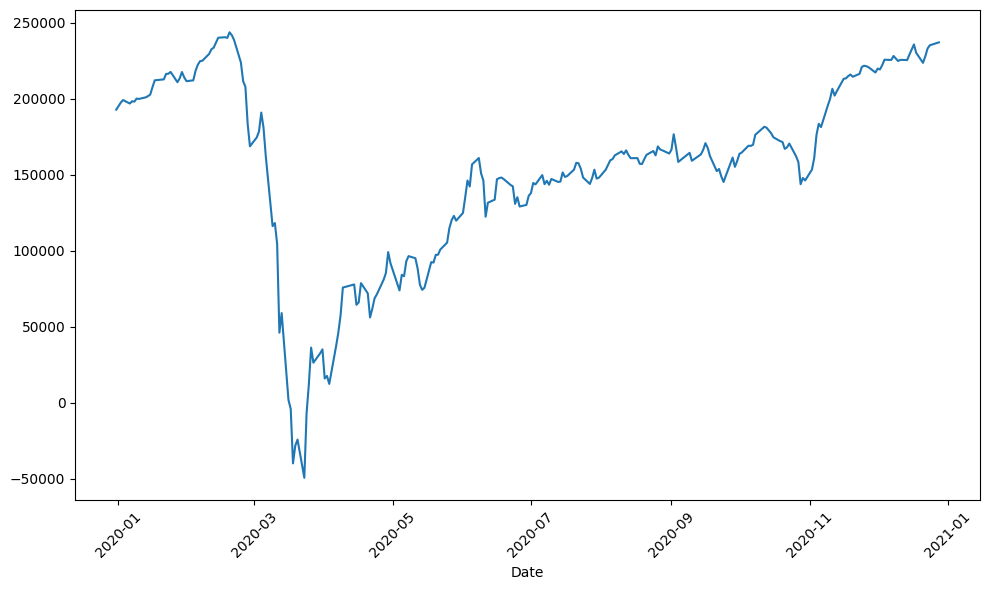

In [ ]:
bof_case_ii = bof.loc["2019-12-31":]

delta_bof_case_ii = bof_case_ii - bof_0

plt.figure(figsize=(10, 6))
plt.plot(delta_bof_case_ii.index, delta_bof_case_ii.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("")
plt.title("")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
asset_names = list(returns_df.columns)

# scenarios_results is assumed to be a nested dictionary:
# { asset_name: { date: scenarios_array, ... }, ... }
# where scenarios_array has shape (n_simulations, window_size)
#
# We want to build a matrix for each date of shape (n_simulations, n_assets),
# where each column is the last value (i.e. cumulative return) from the corresponding asset’s scenarios.

# Get the list of dates for which we have generated scenarios.
# (Assuming the dates are the same across assets, here we take the dates from the first asset.)
all_dates = sorted(list(scenarios_results[asset_names[0]].keys()))

# Dictionary to store SCR for each date.
portfolio_scr_results = {}  # key: date, value: scr

for date in all_dates[:]:
    gan_samples_cols = []
    for asset in asset_names:
        # Retrieve the scenarios for the asset at this date.
        asset_scenarios = scenarios_results[asset][date]  # expected shape: (n_simulations, window_size)
        # Use the last column to represent the cumulative return.
        asset_cum = np.prod(1 + asset_scenarios, axis=1) - 1
        if np.isnan(asset_cum).any() or np.isinf(asset_cum).any():
            print(f"Warning: NaN or Inf encountered in cumulative returns for asset {asset} on date {date}.")
        gan_samples_cols.append(asset_cum.reshape(-1, 1))

    # Stack horizontally so that each column corresponds to one asset.
    gan_samples = np.hstack(gan_samples_cols)  # shape: (n_simulations, n_assets)
    
    # Create a portfolio with the aggregated GAN samples and the specified weights.

    bof_0_case_i = bof.iloc[bof.index.get_loc(date) - 252]

    portfolio = SimpleGANPortfolio(gan_samples, weights, bof0_casei=bof_0_case_i)
    _, scr = portfolio.calculate_distribution_and_scr(case=2)
    
    portfolio_scr_results[date] = scr
    print(f"Date {date}: SCR = {scr}")


Date 2019-12-31 00:00:00: SCR = -125196.73201151706
Date 2020-01-02 00:00:00: SCR = -124351.40033551617
Date 2020-01-03 00:00:00: SCR = -124544.60179856721
Date 2020-01-06 00:00:00: SCR = -125346.08120121805
Date 2020-01-07 00:00:00: SCR = -125246.14770894728
Date 2020-01-08 00:00:00: SCR = -124704.56547940944
Date 2020-01-09 00:00:00: SCR = -124694.87733154287
Date 2020-01-10 00:00:00: SCR = -125789.95041091915
Date 2020-01-13 00:00:00: SCR = -126458.10661001728
Date 2020-01-14 00:00:00: SCR = -126664.40363541737
Date 2020-01-15 00:00:00: SCR = -126117.80206008904
Date 2020-01-16 00:00:00: SCR = -128087.58380592061
Date 2020-01-17 00:00:00: SCR = -127989.75322047912
Date 2020-01-20 00:00:00: SCR = -125998.82875242775
Date 2020-01-21 00:00:00: SCR = -126144.95734138199
Date 2020-01-22 00:00:00: SCR = -127879.57918668195
Date 2020-01-23 00:00:00: SCR = -126284.08101054326
Date 2020-01-24 00:00:00: SCR = -124476.51410003644
Date 2020-01-27 00:00:00: SCR = -124044.02863346633
Date 2020-01

KeyboardInterrupt: 

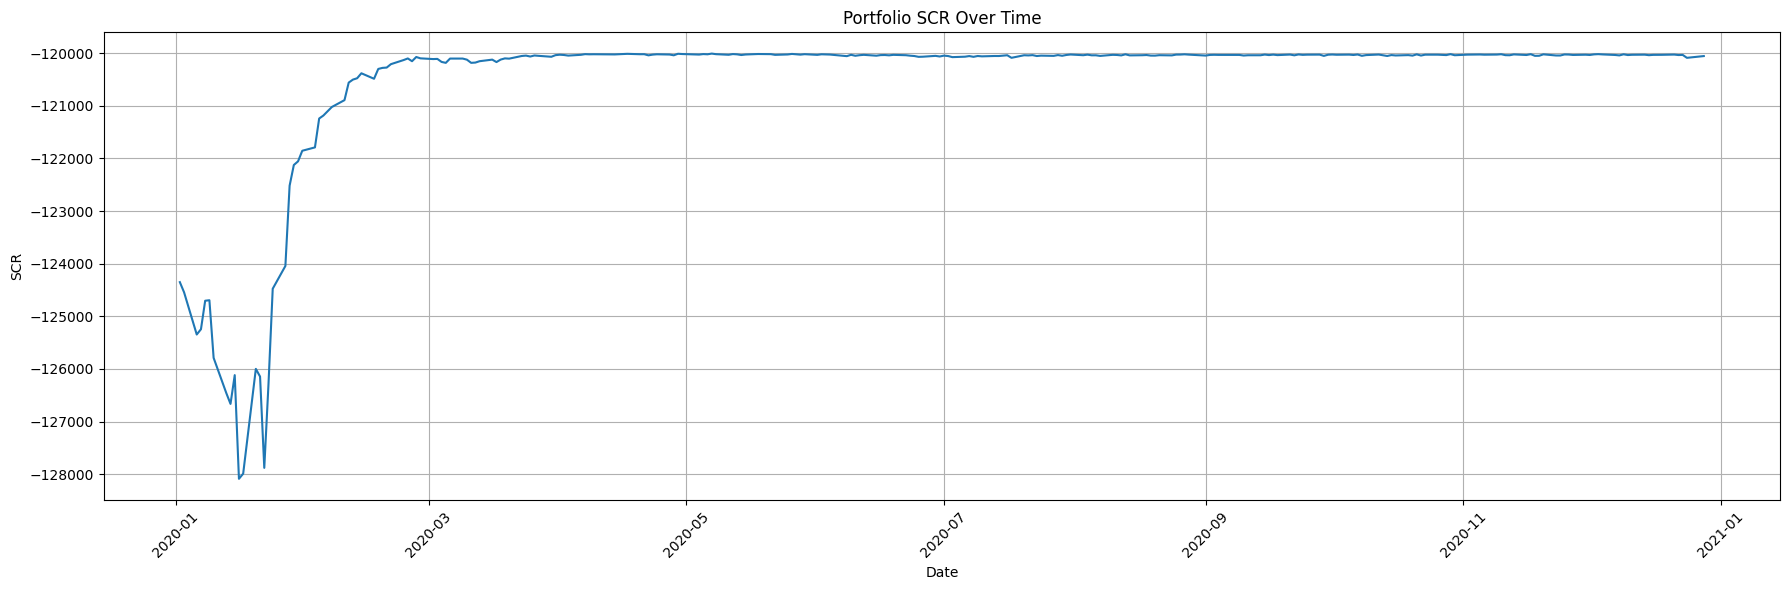

In [ ]:
# Assume portfolio_scr_results is a dictionary with dates as keys and SCR values as values.
# First, sort the dates (this assumes the keys are either datetime objects or strings that sort chronologically)
sorted_dates = sorted(portfolio_scr_results.keys())
scr_values = [portfolio_scr_results[date] for date in sorted_dates]

plt.figure(figsize=(18, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("SCR")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

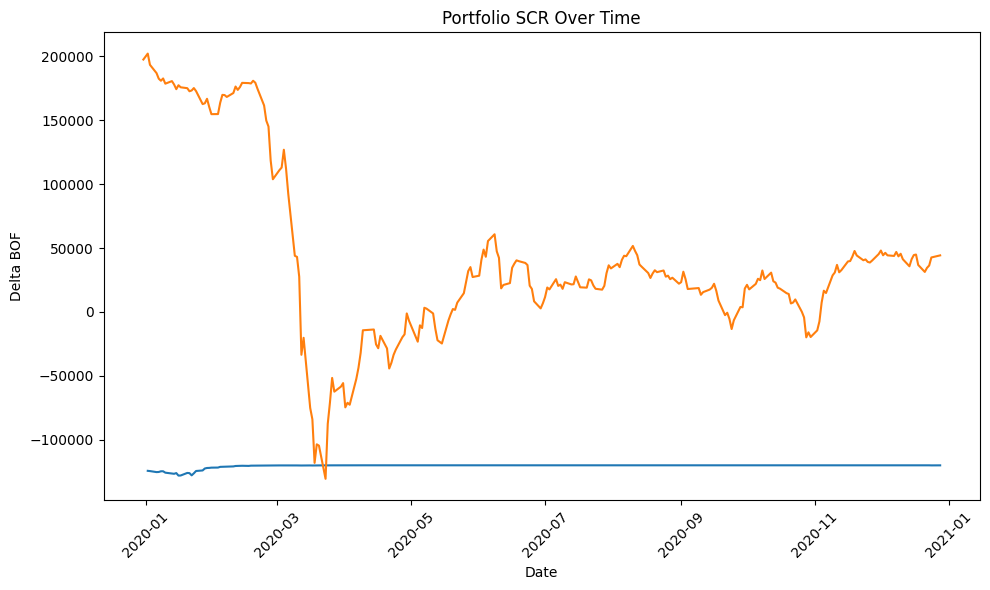

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(sorted_dates, scr_values, linestyle='-')
plt.plot(rolling_delta_bof.index, rolling_delta_bof.values, linestyle='-')
plt.xlabel("Date")
plt.ylabel("Delta BOF")
plt.title("Portfolio SCR Over Time")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

## RESULTS

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_MSCIWORLD_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_IG_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_GOV_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_HY_final_scenarios.pt
Scaled = False
Loaded Generated returns from: generated_GAN_output\generated_returns_EONIA_final_scenarios.pt
Scaled = False


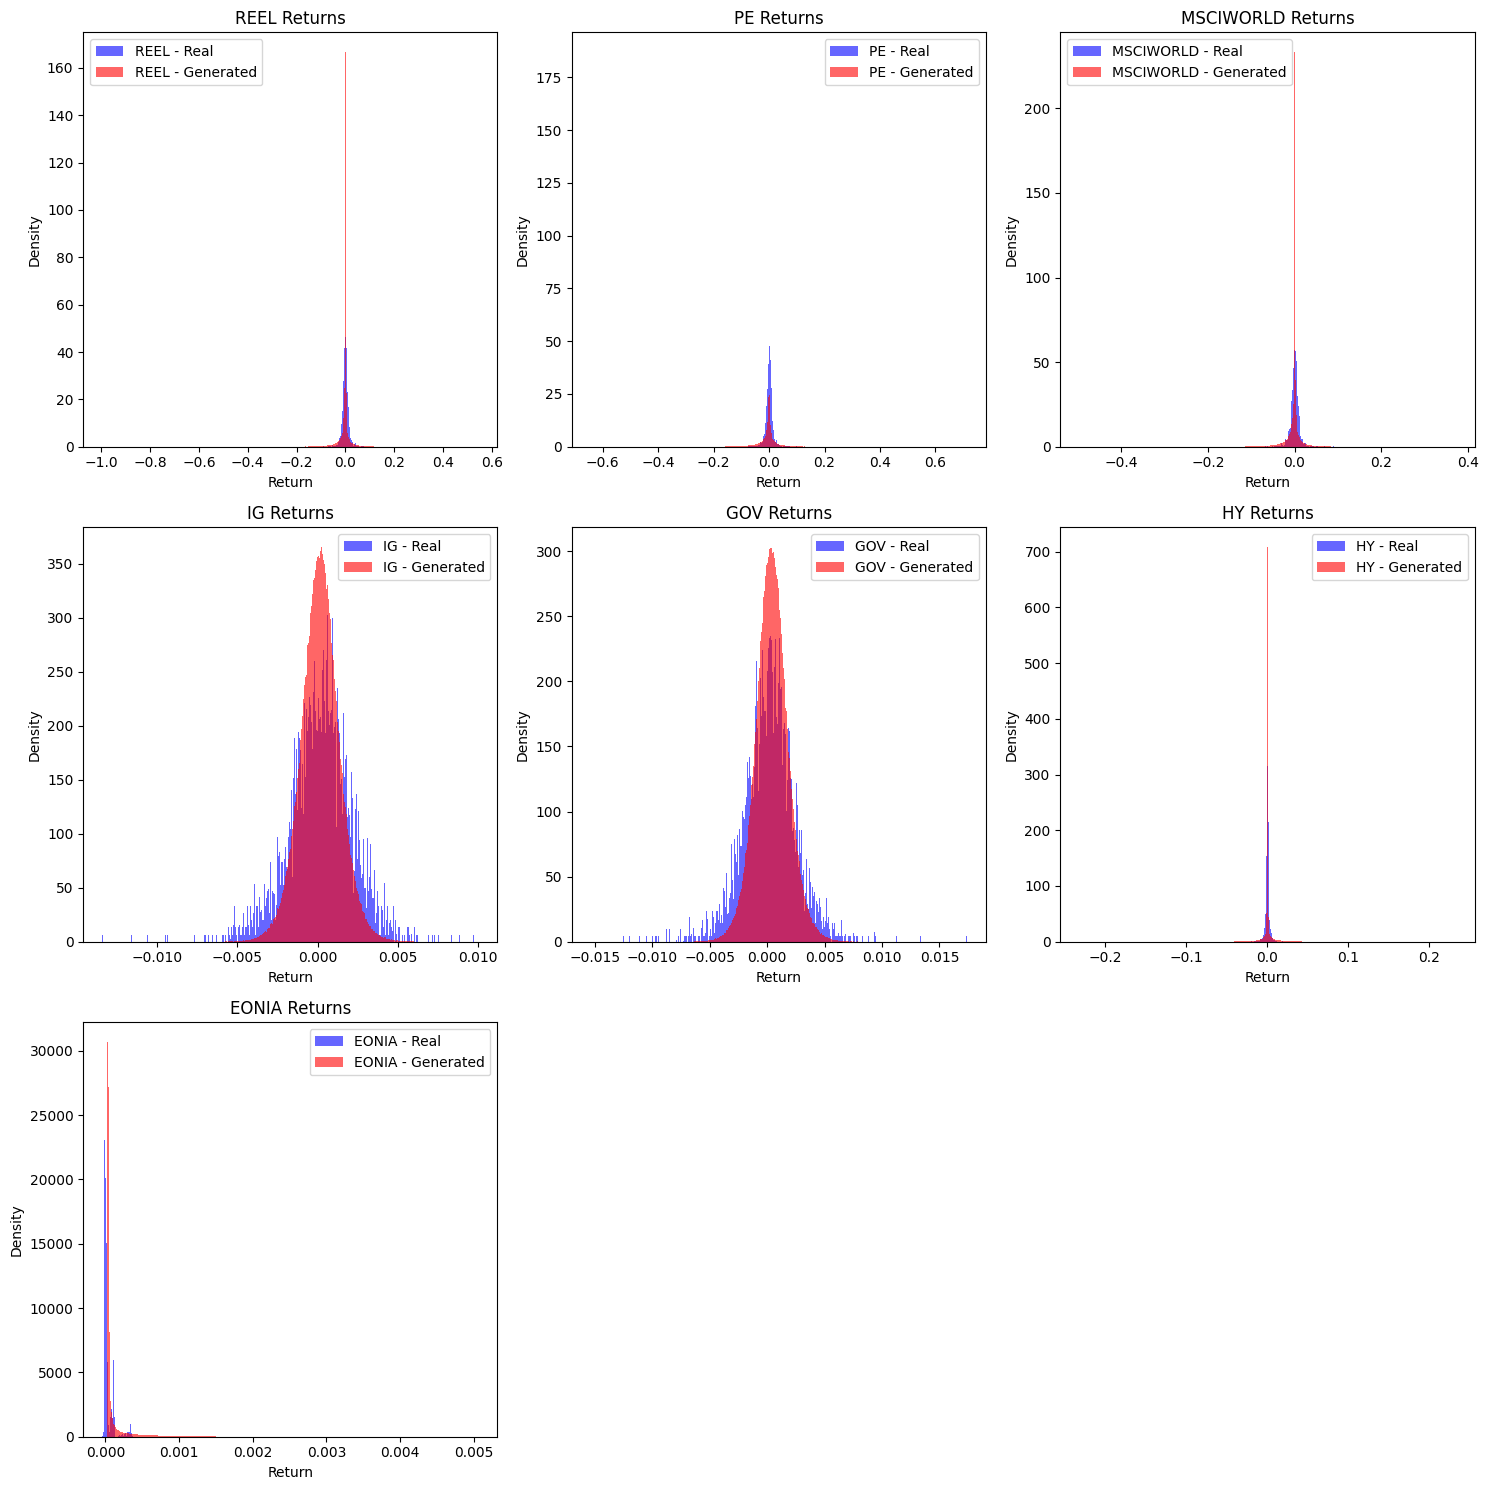


📊 Return Statistics Summary:
                Asset      Mean  Std Dev  Skewness  Kurtosis  99.5% VaR
          REEL - Real  0.000193 0.012916 -0.270455  4.969021  -0.051644
     REEL - Generated -0.003458 0.031310 -2.915666 47.968742  -0.163125
            PE - Real  0.000224 0.012736 -0.303648  6.380382  -0.052287
       PE - Generated -0.003231 0.034888 -1.154012 33.609531  -0.176356
     MSCIWORLD - Real  0.000283 0.009887 -0.226726  7.359869  -0.037021
MSCIWORLD - Generated -0.002518 0.021537 -2.087063 28.640760  -0.112612
            IG - Real  0.000182 0.002083 -0.458256  2.226597  -0.006788
       IG - Generated  0.000163 0.001229  0.016035  0.931641  -0.003327
           GOV - Real  0.000183 0.002449 -0.034370  4.018610  -0.008100
      GOV - Generated  0.000412 0.001460  0.075903  0.989935  -0.003696
            HY - Real  0.000279 0.003002 -1.860565 31.424899  -0.012798
       HY - Generated  0.000462 0.011216 -0.077706 45.425400  -0.052460
         EONIA - Real  0.000032 0.

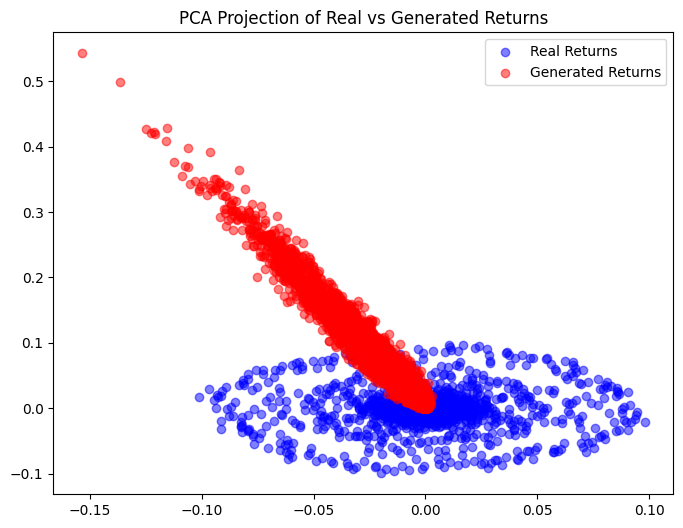

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt


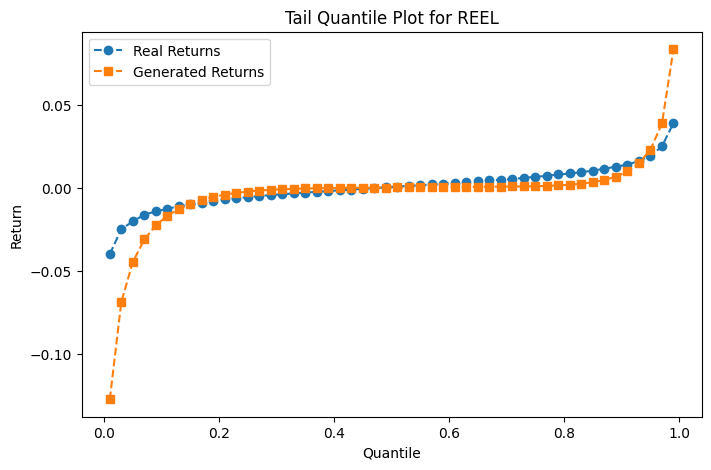


════════════════════════════════════════════════
║  COMPUTING NEAREST DISTANCE HISTOGRAM: REEL  ║
════════════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt

📊 Distance Summary for REEL:
Min Distance: 0.000000
Max Distance: 31.834894
Mean Distance: 0.010271
Median Distance: 0.000217
Standard Deviation: 0.212734


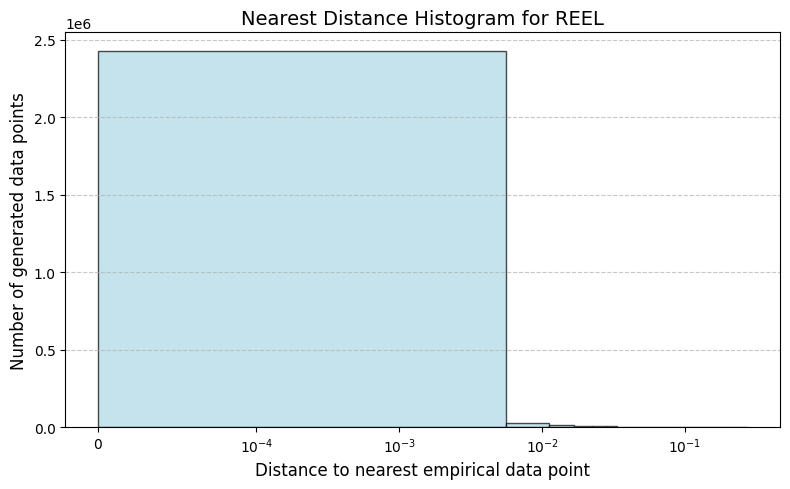


══════════════════════════════════════════
║  COMPUTING WASSERSTEIN DISTANCE: REEL  ║
══════════════════════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_REEL_final_scenarios.pt
📊 Wasserstein Distance for REEL: 0.008069


═════════════════════════
║  ANALYZING ASSET: PE  ║
═════════════════════════

Loaded Generated returns from: generated_GAN_output\generated_returns_PE_final_scenarios.pt
Variance of Real Data: 0.000162
Variance of Generated Data: 0.000972
✅ Generated Data Shows Reasonable Variance


KeyboardInterrupt: 

In [ ]:
extensive_plotting(scaled=False, returns_df=returns_df, test=False, quarterly=False)

# ----------------------------------------------------------

In [ ]:
from utilities.load_generated_quarters import load_all_generated_quarters

In [ ]:
for asset_name in returns_df.columns:
    # Create a new function that loads all fucking quarter for a fucking asset
    generated_returns = load_all_generated_quarters(asset_name, quarterly=True, test=True)

    failures, var_thresholds = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name, quarterly=True)

    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=var_thresholds, asset_name=asset_name, generated_returns=generated_returns)


    perform_distribution_tests(generated_returns=generated_returns[0], empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)


FileNotFoundError: [Errno 2] No such file or directory: 'generated_CGAN_output_test\\q0\\generated_returns_REEL_q0.pt'